In [0]:
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
# !wget https://launchpad.net/~alessandro-strada/+archive/ubuntu/google-drive-ocamlfuse-beta/+build/15331130/+files/google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
# !dpkg -i google-drive-ocamlfuse_0.7.0-0ubuntu1_amd64.deb
# !apt-get install -f
# !apt-get -y install -qq fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

··········


In [0]:

!mkdir -p drive

!google-drive-ocamlfuse drive
!pip install tables
!apt-get install -y -qq python-software-properties module-init-tools

fuse: mountpoint is not empty
fuse: if you are sure this is safe, use the 'nonempty' mount option
E: Package 'python-software-properties' has no installation candidate


In [0]:
!ls -R

In [0]:
!unzip "./drive/Cancer Diagnosis/training_variants.zip"

Archive:  ./drive/Cancer Diagnosis/training_variants.zip
  inflating: training_variants       


In [0]:
!ls 

adc.json  drive  sample_data  training_variants


In [0]:
!unzip "./drive/Cancer Diagnosis/training_text.zip"

Archive:  ./drive/Cancer Diagnosis/training_text.zip
  inflating: training_text           


In [0]:
from nltk.corpus import stopwords

In [0]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re


from sklearn.externals import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_extraction import 
from nltk.corpus import stopwords
from sklearn import preprocessing





In [0]:
data = pd.read_csv('training_variants')
# print(train_var.shape)
# print(train_var.columns)
# print(data.head())

In [0]:
data_text = pd.read_csv('training_text',sep = "\|\|", names = ['ID','Text'],skiprows=1)
# print(train_text.shape)
# print(train_text.columns)
print(data_text.head())
# data_text.columns
data_text.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


   ID                                               Text
0   0  Cyclin-dependent kinases (CDKs) regulate a var...
1   1   Abstract Background  Non-small cell lung canc...
2   2   Abstract Background  Non-small cell lung canc...
3   3  Recent evidence has demonstrated that acquired...
4   4  Oncogenic mutations in the monomeric Casitas B...


(3321, 2)

In [0]:
result  =  pd.merge(data,data_text,on = 'ID', how='left')
result.head()

# result['Class'].value_counts

,ID,Gene,Variation,Class,Text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


In [0]:
!pip3 install nltk

In [0]:
import nltk
nltk.download('stopwords')
# from nltk.corpus import stopwords
stockwords = set(stopwords.words('english'))
result[result.isnull().any(axis=1)]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,ID,Gene,Variation,Class,Text
1109,1109,FANCA,S1088F,1,NaN
1277,1277,ARID5B,Truncating Mutations,1,NaN
1407,1407,FGFR3,K508M,6,NaN
1639,1639,FLT1,Amplification,6,NaN
2755,2755,BRAF,G596C,7,NaN


In [0]:
def prepro(txt,indx,coln):
  if type(txt) is not int:
    st1= ""
    txt = re.sub('[^a-zA-Z0-9]',' ',txt)
    txt = re.sub('\s+', ' ',txt)
    txt = txt.lower()
    
    for i in txt.split():
      if i not in stockwords:
        st1 = i+' '
        
    result[coln][indx] = st1
    

In [0]:
%%time
for index, row in data_text.iterrows():
    if type(row['Text']) is str:
        prepro(row['Text'], index, 'Text')
    else:
        print("there is no text description for id:",index)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


there is no text description for id: 1109
there is no text description for id: 1277
there is no text description for id: 1407
there is no text description for id: 1639
there is no text description for id: 2755
CPU times: user 2min 50s, sys: 85.7 ms, total: 2min 50s
Wall time: 2min 50s


In [0]:
result.loc[result['Text'].isnull(),'Text'] = result['Gene']+''+result['Variation']

In [0]:
#result[result['ID'] == 2755]

result.Gene = result.Gene.str.replace('\s+','_')
result.Variation = result.Variation.str.replace('\s+', '_')

In [0]:
# -------------- data split -------------

from sklearn.model_selection import train_test_split

y_true = result['Class'].values
x_red,x_test,y_red,y_test = train_test_split(result,y_true,test_size=0.2,stratify = y_true)

x_tr,x_cv,y_tr,y_cv = train_test_split(x_red, y_red, test_size = 0.2, stratify = y_red)

x_tr.shape

(2124, 5)

In [0]:
file_name = "./drive/Cancer Diagnosis/cancer_data.pkl"
cd = open(file_name,"wb")
pickle.dump(result,cd)
cd.close()
print(result.shape)

(3321, 5)


In [0]:
import pickle
file_name = "./drive/Cancer Diagnosis/cancer_data.pkl"
cd = open(file_name,"rb")
result = pickle.load(cd)
print(result.shape)

# import pickle

# file_name = "./drive/Colab Notebooks/amazon/amazon_data.pkl"
# amaz = open(file_name,"rb")
# fin = pickle.load(amaz)
# print(fin.shape)

(3321, 5)


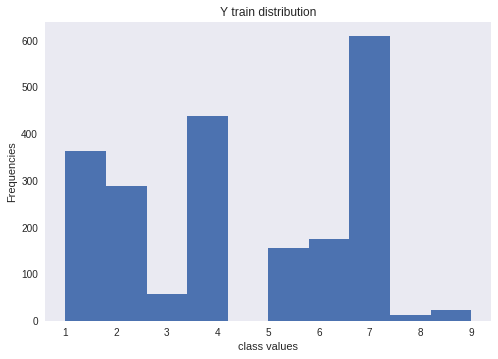

In [0]:
val = x_tr['Class'].values
plt.hist(val)
plt.title('Y train distribution')
plt.xlabel('class values')
plt.ylabel('Frequencies')
plt.grid()
plt.show()


In [0]:
result.describe()

,ID,Class
count,3321.000000,3321.000000
mean,1660.000000,4.365854
std,958.834449,2.309781
min,0.000000,1.000000
25%,830.000000,2.000000
50%,1660.000000,4.000000
75%,2490.000000,7.000000
max,3320.000000,9.000000


In [0]:
ge = x_tr['Gene'].value_counts()

print(ge.shape)
ge.head(10)

(232,)


BRCA1     175
TP53      110
EGFR       92
BRCA2      80
PTEN       80
KIT        60
BRAF       59
ERBB2      50
ALK        48
CDKN2A     40
Name: Gene, dtype: int64

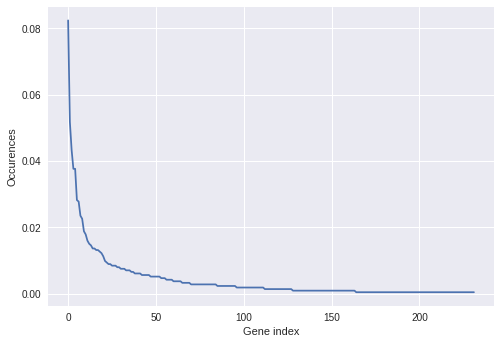

In [0]:
s = sum(ge.values)
h = ge.values/s
plt.plot(h,label = 'Gene histograme')
plt.xlabel('Gene index')
plt.ylabel('Occurences')
# plt.grid()
plt.show()

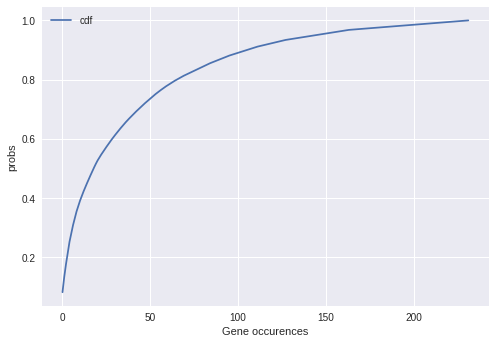

In [0]:
cu = np.cumsum(h)
plt.plot(cu,label = "cdf")
plt.xlabel('Gene occurences')
plt.ylabel('probs')
plt.legend()
plt.show()

In [0]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize

onehot = CountVectorizer()
train_gene_feat = onehot.fit_transform(x_tr['Gene'])
cv_gene_feat = onehot.transform(x_cv['Gene'])
test_gene_feat = onehot.transform(x_test['Gene'])

train_var_feat = onehot.fit_transform(x_tr['Variation'])
cv_var_feat = onehot.transform(x_cv['Variation'])
test_var_feat = onehot.transform(x_test['Variation'])

text_vectorizer = CountVectorizer(min_df=3)
train_text_feature_onehotCoding = text_vectorizer.fit_transform(x_tr['Text'])

# don't forget to normalize every feature
train_text_feature_onehotCoding = normalize(train_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
test_text_feature_onehotCoding = text_vectorizer.transform(x_test['Text'])
# don't forget to normalize every feature
test_text_feature_onehotCoding = normalize(test_text_feature_onehotCoding, axis=0)

# we use the same vectorizer that was trained on train data
cv_text_feature_onehotCoding = text_vectorizer.transform(x_cv['Text'])
# don't forget to normalize every feature
cv_text_feature_onehotCoding = normalize(cv_text_feature_onehotCoding, axis=0)


# train_text_feat = onehot.fit_transform(x_tr('Text'))
# cv_text_feat = onehot.transform(x_cv['Text'])
# test_text_feat = onehot.transform(x_test['Text'])

In [0]:
from scipy.sparse import hstack
# from sklear.preprocessing import LabelEncoder()

train_gene_var_onehotCoding =hstack((train_gene_feat,train_var_feat))
test_gene_var_onehotCoding = hstack((test_gene_feat,test_var_feat))
cv_gene_var_onehotCoding = hstack((cv_gene_feat,cv_var_feat))

train_x_onehotCoding = hstack((train_gene_var_onehotCoding, train_text_feature_onehotCoding)).tocsr()
test_x_onehotCoding = hstack((test_gene_var_onehotCoding, test_text_feature_onehotCoding)).tocsr()
cv_x_onehotCoding = hstack((cv_gene_var_onehotCoding, cv_text_feature_onehotCoding)).tocsr()


# le = LabelEncoder()
train_y = np.array(list(x_tr['Class']))

test_y = np.array(list(x_test['Class']))

cv_y = np.array(list(x_cv['Class']))



In [0]:
from sklearn.linear_model.stochastic_gradient import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import log_loss


cv_log_error_array=[]
alpha = [1e-5,1e-4,1e-3,1e-2]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=73)
    clf.fit(train_gene_feat, y_tr)
    
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_gene_feat, y_tr)
    
    predict_y = sig_clf.predict_proba(cv_gene_feat)
    
    cv_log_error_array.append(log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
    

best_alpha = np.argmin(cv_log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=113)
clf.fit(train_gene_feat, y_tr)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(train_gene_feat, y_tr)

predict_y = sig_clf.predict_proba(train_gene_feat)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_tr, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(cv_gene_feat)
print('For values of best alpha = ', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_cv, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(test_gene_feat)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))


    

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and defa

For values of alpha =  1e-05 The log loss is: 1.3750861362422966
For values of alpha =  0.0001 The log loss is: 1.2304433185802481


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  wa

For values of alpha =  0.001 The log loss is: 1.2424305090926506
For values of alpha =  0.01 The log loss is: 1.355475052262498


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=No

For values of best alpha =  0.0001 The train log loss is: 1.050832858180081
For values of best alpha =  0.0001 The cross validation log loss is: 1.2278038309647794
For values of best alpha =  0.0001 The test log loss is: 1.2186416269842837


In [0]:
#----------- ML MODELS ----------------
%%time
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

param_grid = {'C':[1,10,1e2,1e3,1e4,1e5]}
mod1 = LogisticRegression(penalty='l2',random_state=113,class_weight='balanced')

grid1 = GridSearchCV(mod1,param_grid = param_grid)
grid1.fit(train_x_onehotCoding, train_y)

print("Best params for LogisticReg is ",grid1.best_params_)  #100000



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Best params for LogisticReg is  {'C': 10}
CPU times: user 1.16 s, sys: 1.99 ms, total: 1.16 s
Wall time: 1.17 s


In [0]:
%%time
param_grid = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,0.5,1]}

mod2 = SGDClassifier(loss='log', penalty='l2',random_state=113,class_weight='balanced')

grid2 = GridSearchCV(mod2,param_grid = param_grid) 
grid2.fit(train_x_onehotCoding, train_y)
print("Best params for sgd is ",grid2.best_params_)  #0.0001



/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Best params for sgd is  {'alpha': 0.0001}
CPU times: user 319 ms, sys: 999 µs, total: 320 ms
Wall time: 320 ms


In [0]:
%%time
# x = np.linspace(1e-5,1e-1,10)
# param_grid = {'alpha':[x]}

param_grid = {'alpha':[1e-5,1e-4,1e-3,1e-2,1e-1,0.5,1]}

mod3 = MultinomialNB()

grid3 = GridSearchCV(mod3,param_grid = param_grid) 
grid3.fit(train_x_onehotCoding, train_y)
print("Best params for sgd is ",grid3.best_params_)  #0.5


Best params for sgd is  {'alpha': 0.5}
CPU times: user 86.3 ms, sys: 2.99 ms, total: 89.3 ms
Wall time: 88.6 ms


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [0]:
def predict_and_plot_confusion_matrix(train_x, train_y,test_x, test_y, clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    pred_y = sig_clf.predict(test_x)

    # for calculating log_loss we willl provide the array of probabilities belongs to each class
    print("Log loss :",log_loss(test_y, sig_clf.predict_proba(test_x)))
    # calculating the number of data points that are misclassified
    print("Number of mis-classified points :", np.count_nonzero((pred_y- test_y))/test_y.shape[0])

    

In [0]:
def report_log_loss(train_x, train_y, test_x, test_y,  clf):
    clf.fit(train_x, train_y)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(train_x, train_y)
    sig_clf_probs = sig_clf.predict_proba(test_x)
    return log_loss(test_y, sig_clf_probs, eps=1e-15)

In [0]:
mod2 = SGDClassifier(loss='log', penalty='l2', random_state=113, class_weight='balanced' , alpha=.0001)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, mod2)

Log loss : 1.0386873895203403
Number of mis-classified points : 0.34398496240601506


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and defa

In [0]:
mod1 = LogisticRegression(penalty='l2',random_state=113,class_weight='balanced',C = 100000)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, mod1)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWar

Log loss : 1.0840293838084807
Number of mis-classified points : 0.36278195488721804


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


In [0]:
mod3 = MultinomialNB(alpha = 0.5)
predict_and_plot_confusion_matrix(train_x_onehotCoding, train_y, cv_x_onehotCoding, cv_y, mod3)

Log loss : 1.1065818951747992
Number of mis-classified points : 0.38721804511278196


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
